In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["JAX_PLATFORMS"] = "cpu"
import sys
sys.path.append('../')
from pathlib import Path
import numpy as np
import random as rd
import utils as u
import visualizer as v
import simulation_models.modelloader as ml
import surrogate_methods.surrogatebuilder as sb
from abi.abi_base import ABI
import json
import time
import json

import matplotlib.pyplot as plt

# set random seed
rd.seed(0)
np.random.seed(0)

In [ ]:
epost_results_path = Path("../results/log_sin-runtimes_laptop")
uasabi_results_path = Path("../results/log_sin-runtimes_laptop")

In [3]:
# find all folders with results in epost_results_path
folders = [f.resolve() for f in epost_results_path.iterdir() if f.is_dir() and f.name[0].isdigit()]
print(folders)

epost_runtimes = {}

# load runtimes for mcmc/epost
for folder in folders:
    config_file = list(folder.glob("*.json"))[0]
    config = u.read_config(config_file)
    inference = config.inference

    if inference == "mcmc":
        times_path = os.path.join(folder, "diagnosis", "time.json")
        with open(times_path, 'r', encoding='utf-8') as file:
            times = json.load(file)
        epost_runtimes[config.out.n_datasets] = times["mcmc_sampling_time"]

[PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-42-13'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-22-32'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-24-31'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-34-24'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-28-31')]


In [4]:
# find all folders with results in uasabi_results_path
folders = [f.resolve() for f in uasabi_results_path.iterdir() if f.is_dir() and f.name[0].isdigit()]
print(folders)

uasabi_runtimes  = {}

# load already calculated runtimes for and model for ua-sabi
for folder in folders:
    config_file = list(folder.glob("*.json"))[0]
    config = u.read_config(config_file)
    inference = config.inference

    if inference == "abi":
        times_path = os.path.join(folder, "diagnosis", "time.json")
        with open(times_path, 'r', encoding='utf-8') as file:
            times = json.load(file)

        uasabi_trainingtime = times["abi_training_time"]
        uasabi_runtimes[config.out.n_datasets] = times["abi_training_time"] + times["abi_sampling_time"]

        uasabi_config = config

        trained_abi_folder = folder

[PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-42-13'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-22-32'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-24-31'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-34-24'), PosixPath('/data/homes/reiser/projects/sabi/results/log_sin-runtime_laptop/2025-03-24_18-28-31')]


In [5]:
# find all n_datasets calculated for mcmc/epost
all_n_datasets = list(epost_runtimes.keys())

# exclude n_datasets that are already in uasabi_runtimes
for n_datasets in all_n_datasets:
    if n_datasets in uasabi_runtimes:
        del all_n_datasets[all_n_datasets.index(n_datasets)]

print(all_n_datasets)

[5, 10, 15]


Either rerun the following cell to measure runtime for missing n_datasets for UA-SABI

In [ ]:
# sample missing n_datasets for uasabi
modelloader = ml.ModelLoader(uasabi_config)
model = modelloader.get_model()

abi = ABI(uasabi_config, model, None)
_, approximator = abi.load(trained_abi_folder)
simulator = model.get_simulator()

for n_datasets in all_n_datasets:
    out_datasets = simulator.sample(n_datasets)

    conditions = {k: v for k, v in out_datasets.items() if k not in model.get_param_names()}

    start_time = time.time()
    parameter_draws = approximator.sample(conditions=conditions, num_samples=uasabi_config.out.n_param_samples)
    end_time = time.time()
    sampling_time = end_time - start_time

    uasabi_runtimes[n_datasets] = uasabi_trainingtime + sampling_time

/home/ac140748/miniconda3/envs/sabi_env/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [30]:
# save runtimes
with open(os.path.join(epost_results_path, 'epost_runtimes.json'), 'w') as f:
    json.dump({str(k): v for k, v in epost_runtimes.items()}, f)
with open(os.path.join(uasabi_results_path, 'uasabi_runtimes.json'), 'w') as f:
    json.dump({str(k): v for k, v in uasabi_runtimes.items()}, f)

Or load the runtimes from the json file

In [6]:
# load runtimes
with open(os.path.join(epost_results_path, 'epost_runtimes.json'), 'r') as f:
    epost_runtimes = {int(k): v for k, v in json.load(f).items()}
with open(os.path.join(uasabi_results_path, 'uasabi_runtimes.json'), 'r') as f:
    uasabi_runtimes = {int(k): v for k, v in json.load(f).items()}

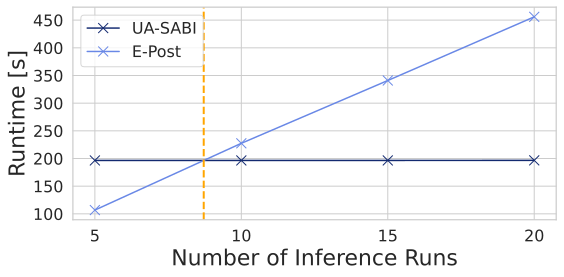

{20: 196.64389419555664, 5: 196.47565388679504, 10: 196.50064611434937, 15: 196.50444149971008}
{5: 106.82761478424072, 10: 227.45712184906006, 20: 455.94673800468445, 15: 340.93544459342957}


In [7]:
uasabi_config.output_path = uasabi_results_path

vis = v.Visualizer(uasabi_config)
vis.compare_runtimes(uasabi_runtimes, epost_runtimes)

print(uasabi_runtimes)
print(epost_runtimes)